# Sport Image Classification

#### Objective: The main objective is to classify different images by sports

#### Dataset: https://www.kaggle.com/datasets/gpiosenka/sports-classification

## Inicialization

In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import tensorflow as tf
from tensorflow.keras import layers, models, applications
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

In [3]:
df = pd.read_csv('sports.csv')
classes = df['labels'].unique()

In [4]:
df

,class id,filepaths,labels,data set
0,0,train/air hockey/001.jpg,air hockey,train
1,0,train/air hockey/002.jpg,air hockey,train
2,0,train/air hockey/003.jpg,air hockey,train
3,0,train/air hockey/004.jpg,air hockey,train
4,0,train/air hockey/005.jpg,air hockey,train
...,...,...,...,...
14488,99,valid/wingsuit flying/1.jpg,wingsuit flying,valid
14489,99,valid/wingsuit flying/2.jpg,wingsuit flying,valid
14490,99,valid/wingsuit flying/3.jpg,wingsuit flying,valid
14491,99,valid/wingsuit flying/4.jpg,wingsuit flying,valid


In [5]:
train_df = df[df['data set'] == 'train']
class_distribution = train_df['labels'].value_counts()
print(f"Training Class distribution - min: {min(class_distribution)}, max: {max(class_distribution)}")

Training Class distribution - min: 59, max: 191


## Selecting Directories to form Datasets

In [6]:
train_dir = 'train'
val_dir = 'valid'
test_dir = 'test'

In [7]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

In [8]:
train_set = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    labels='inferred',
    label_mode='categorical',
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    shuffle=True
)

val_set = tf.keras.utils.image_dataset_from_directory(
    val_dir,
    labels='inferred',
    label_mode='categorical',
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    shuffle=False
)

test_set = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    labels='inferred',
    label_mode='categorical',
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    shuffle=False
)

Found 13492 files belonging to 100 classes.
Found 500 files belonging to 100 classes.
Found 500 files belonging to 100 classes.


In [9]:
class_names = test_set.class_names
print(f"Class names: {class_names}")

Class names: ['air hockey', 'ampute football', 'archery', 'arm wrestling', 'axe throwing', 'balance beam', 'barell racing', 'baseball', 'basketball', 'baton twirling', 'bike polo', 'billiards', 'bmx', 'bobsled', 'bowling', 'boxing', 'bull riding', 'bungee jumping', 'canoe slamon', 'cheerleading', 'chuckwagon racing', 'cricket', 'croquet', 'curling', 'disc golf', 'fencing', 'field hockey', 'figure skating men', 'figure skating pairs', 'figure skating women', 'fly fishing', 'football', 'formula 1 racing', 'frisbee', 'gaga', 'giant slalom', 'golf', 'hammer throw', 'hang gliding', 'harness racing', 'high jump', 'hockey', 'horse jumping', 'horse racing', 'horseshoe pitching', 'hurdles', 'hydroplane racing', 'ice climbing', 'ice yachting', 'jai alai', 'javelin', 'jousting', 'judo', 'lacrosse', 'log rolling', 'luge', 'motorcycle racing', 'mushing', 'nascar racing', 'olympic wrestling', 'parallel bar', 'pole climbing', 'pole dancing', 'pole vault', 'polo', 'pommel horse', 'rings', 'rock climbi

## Preparing Datasets

In [10]:
data_augmentation = models.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.3),
    layers.RandomZoom(0.2),
    layers.RandomTranslation(0.2, 0.2),
    layers.RandomContrast(0.2),
    layers.RandomBrightness(0.2)
])

In [11]:
train_set = train_set.map(lambda x, y: (tf.cast(data_augmentation(x), tf.float32) / 255.0, y))
val_set = val_set.map(lambda x, y: (tf.cast(x, tf.float32) / 255.0, y))
test_set = test_set.map(lambda x, y: (tf.cast(x, tf.float32) / 255.0, y))

In [12]:
train_set = train_set.cache().prefetch(tf.data.AUTOTUNE)

In [13]:
total_samples = len(train_df)
n_classes = len(class_distribution)
class_weight_dict = {
    i: total_samples / (n_classes * count)
    for i, (label, count) in enumerate(class_distribution.items())
}

## Building model

In [14]:
base_model = applications.MobileNetV2(
    weights='imagenet',
    include_top=False,
    input_shape=(*IMG_SIZE, 3)
)

for layer in base_model.layers:
    layer.trainable = False

In [15]:
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=5,
    min_lr=1e-6,
    verbose=1
)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=15,
    restore_best_weights=True,
    verbose=1
)

In [16]:
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.BatchNormalization(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(len(classes), activation='softmax')
])

In [17]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=[
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall'),
        tf.keras.metrics.AUC(name='auc')
    ]
)

## Training

In [18]:
checkpoint_dir = './training_checkpoints'
os.makedirs(checkpoint_dir, exist_ok=True)

checkpoint_best = ModelCheckpoint(
    filepath='best_model.keras',
    save_best_only=True,
    monitor='val_loss',
    mode='min',
    verbose=1
)

checkpoint_path = os.path.join(checkpoint_dir, 'cp-{epoch:04d}.weights.h5')
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    verbose=1,
    save_weights_only=True,
    save_freq='epoch'
)

In [19]:
latest_checkpoint = tf.train.latest_checkpoint(checkpoint_dir)
if latest_checkpoint:
    print(f"Reanudando entrenamiento desde: {latest_checkpoint}")
    model.load_weights(latest_checkpoint)
    # Extract epoch number from checkpoint name
    initial_epoch = int(os.path.basename(latest_checkpoint).split('-')[1].split('.')[0])
else:
    initial_epoch = 0

In [ ]:
history = model.fit(
    train_set,
    epochs=100,
    initial_epoch=initial_epoch,
    validation_data=val_set,
    class_weight=class_weight_dict,
    callbacks=[reduce_lr, early_stopping, checkpoint_best, checkpoint_callback]
)

Epoch 1/100
422/422 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.0272 - auc: 0.5645 - loss: 5.3475 - precision: 0.0549 - recall: 4.8582e-04
Epoch 1: val_loss improved from inf to 3.66165, saving model to best_model.keras

Epoch 1: saving model to ./training_checkpoints\cp-0001.weights.h5
422/422 ━━━━━━━━━━━━━━━━━━━━ 489s 1s/step - accuracy: 0.0273 - auc: 0.5647 - loss: 5.3466 - precision: 0.0551 - recall: 4.8748e-04 - val_accuracy: 0.1820 - val_auc: 0.8274 - val_loss: 3.6617 - val_precision: 0.7500 - val_recall: 0.0120 - learning_rate: 1.0000e-04
Epoch 2/100
422/422 ━━━━━━━━━━━━━━━━━━━━ 0s 624ms/step - accuracy: 0.1410 - auc: 0.7872 - loss: 3.9049 - precision: 0.5949 - recall: 0.0132
Epoch 2: val_loss improved from 3.66165 to 2.77974, saving model to best_model.keras

Epoch 2: saving model to ./training_checkpoints\cp-0002.weights.h5
422/422 ━━━━━━━━━━━━━━━━━━━━ 273s 647ms/step - accuracy: 0.1410 - auc: 0.7872 - loss: 3.9046 - precision: 0.5950 - recall: 0.0132 - val_accuracy: 0.3700 

## Testing and Evaluating results

In [20]:
sport_clf = tf.keras.models.load_model('best_model.keras')

In [21]:
test_loss, test_accuracy, test_precision, test_recall, test_auc = sport_clf.evaluate(test_set)
print(f"Test accuracy: {test_accuracy:.4f}")
print(f"Test precision: {test_precision:.4f}")
print(f"Test recall: {test_recall:.4f}")
print(f"Test auc: {test_auc:.4f}")

16/16 ━━━━━━━━━━━━━━━━━━━━ 15s 635ms/step - accuracy: 0.7570 - auc: 0.9837 - loss: 0.8383 - precision: 0.8229 - recall: 0.6885
Test accuracy: 0.7500
Test precision: 0.8293
Test recall: 0.6900
Test auc: 0.9890


In [ ]:
train_df

,class id,filepaths,labels,data set
0,0,train/air hockey/001.jpg,air hockey,train
1,0,train/air hockey/002.jpg,air hockey,train
2,0,train/air hockey/003.jpg,air hockey,train
3,0,train/air hockey/004.jpg,air hockey,train
4,0,train/air hockey/005.jpg,air hockey,train
...,...,...,...,...
13488,99,train/wingsuit flying/94.jpg,wingsuit flying,train
13489,99,train/wingsuit flying/95.jpg,wingsuit flying,train
13490,99,train/wingsuit flying/96.jpg,wingsuit flying,train
13491,99,train/wingsuit flying/97.jpg,wingsuit flying,train


In [31]:
y_true_list = []
y_pred_list = []
y_pred_probs = []

In [32]:
for images, labels in test_set:
    predictions = sport_clf.predict(images)
    y_pred = np.argmax(predictions, axis=1)
    y_true = np.argmax(labels.numpy(), axis=1)

    y_pred_list.extend(y_pred)
    y_true_list.extend(y_true)
    y_pred_probs.extend(predictions)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 905ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 619ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 589ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 578ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 614ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 586ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 617ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 582ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 568ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 720ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 625ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 693ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 607ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 889ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 683ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 547ms/step


In [33]:


class_report = classification_report(y_true_list, y_pred_list,
                                    target_names=class_names,
                                    output_dict=True)

# Convert to DataFrame for easier analysis
report_df = pd.DataFrame(class_report).transpose()

# Filter out the averages rows
class_metrics = report_df.iloc[:-3]

# Sort by recall to find best and worst performing classes
worst_classes = class_metrics.sort_values(by='recall').head(15)
best_classes = class_metrics.sort_values(by='recall', ascending=False).head(15)

c:\Users\David\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\David\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\David\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

### Visualize best and worst classes

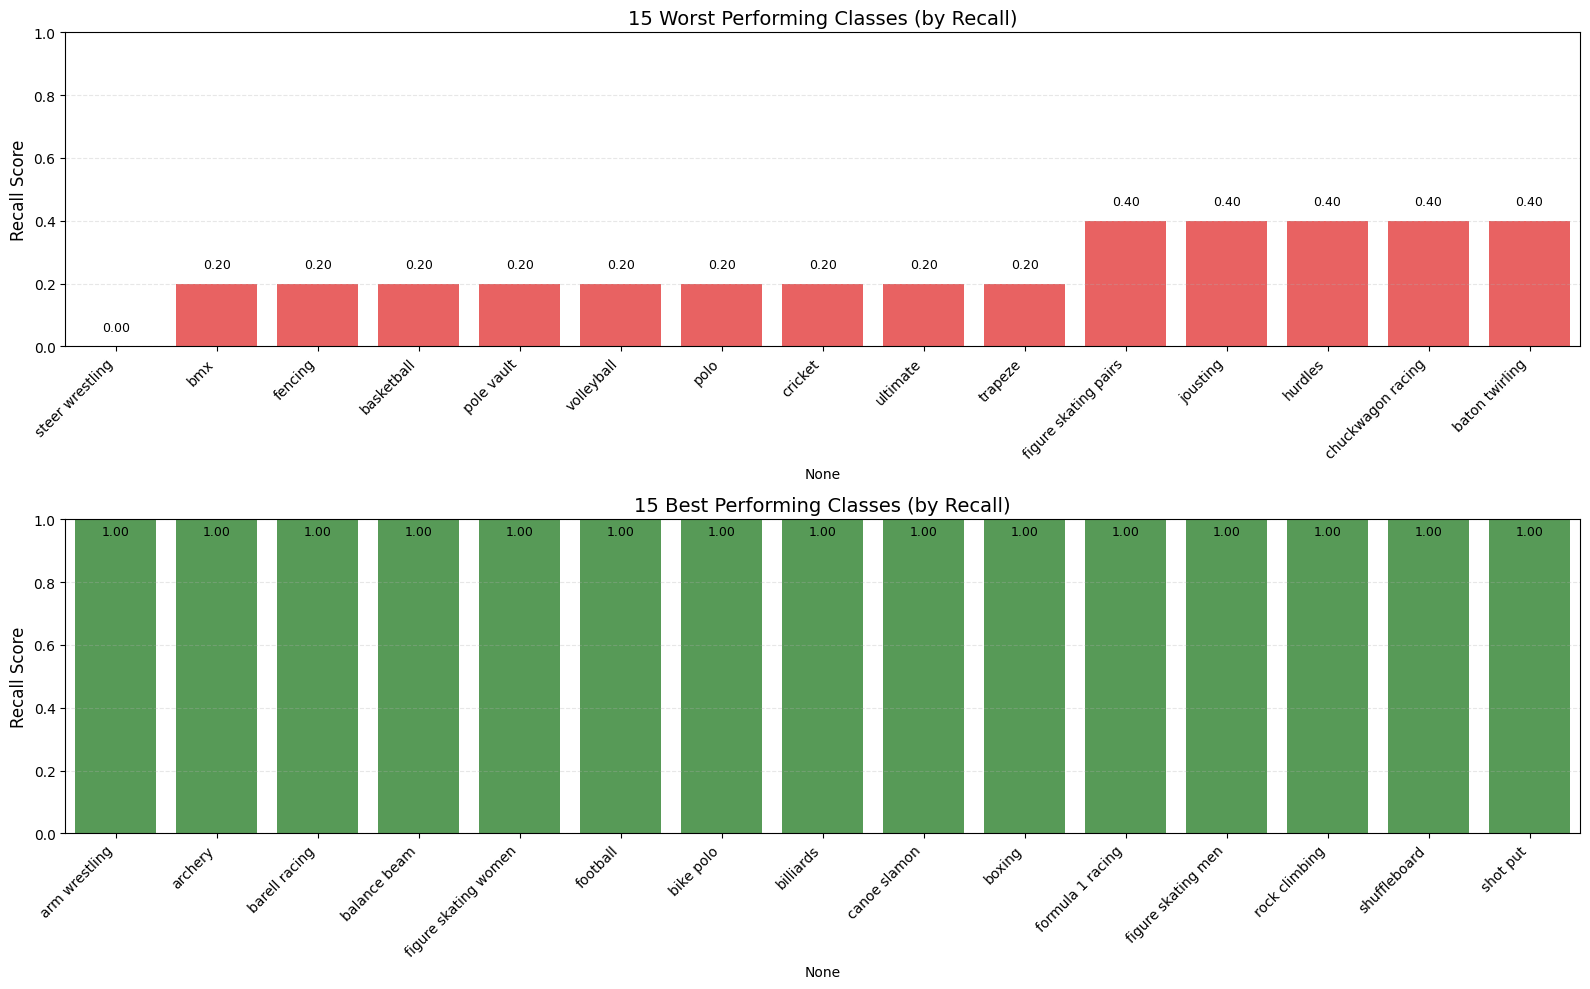

<Figure size 1600x800 with 0 Axes>

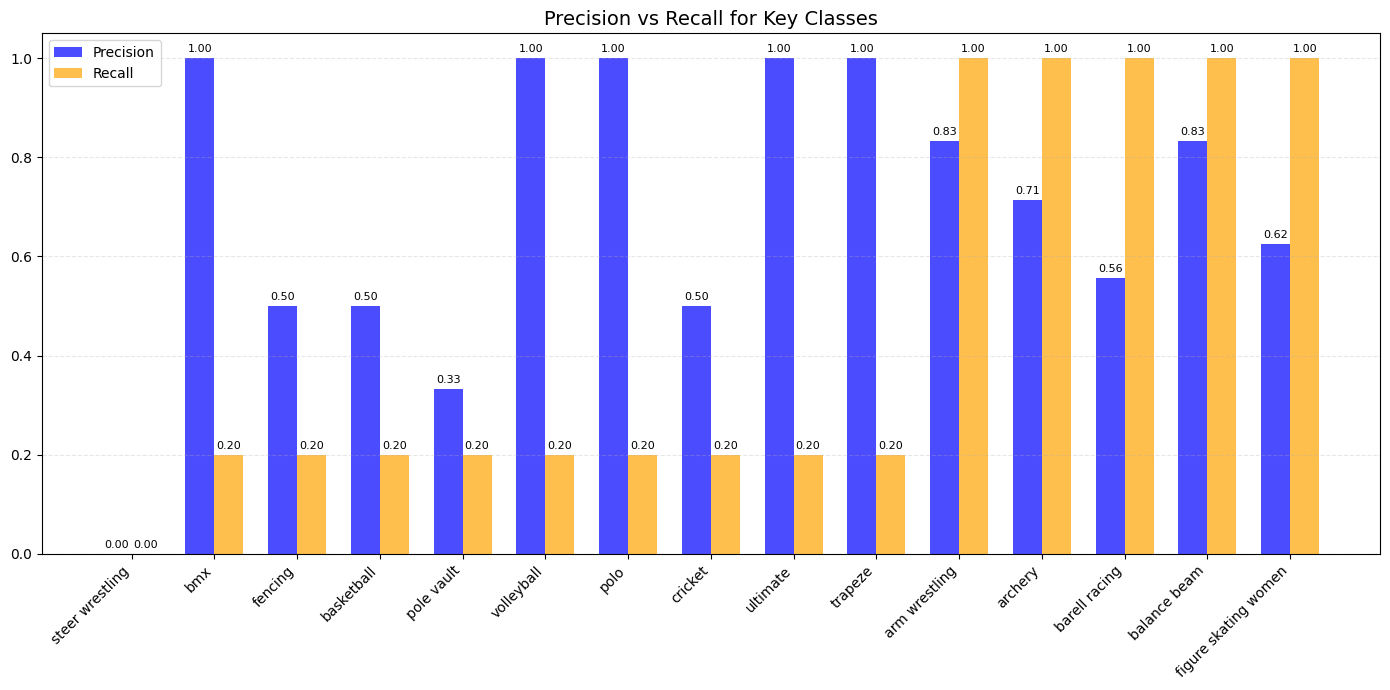

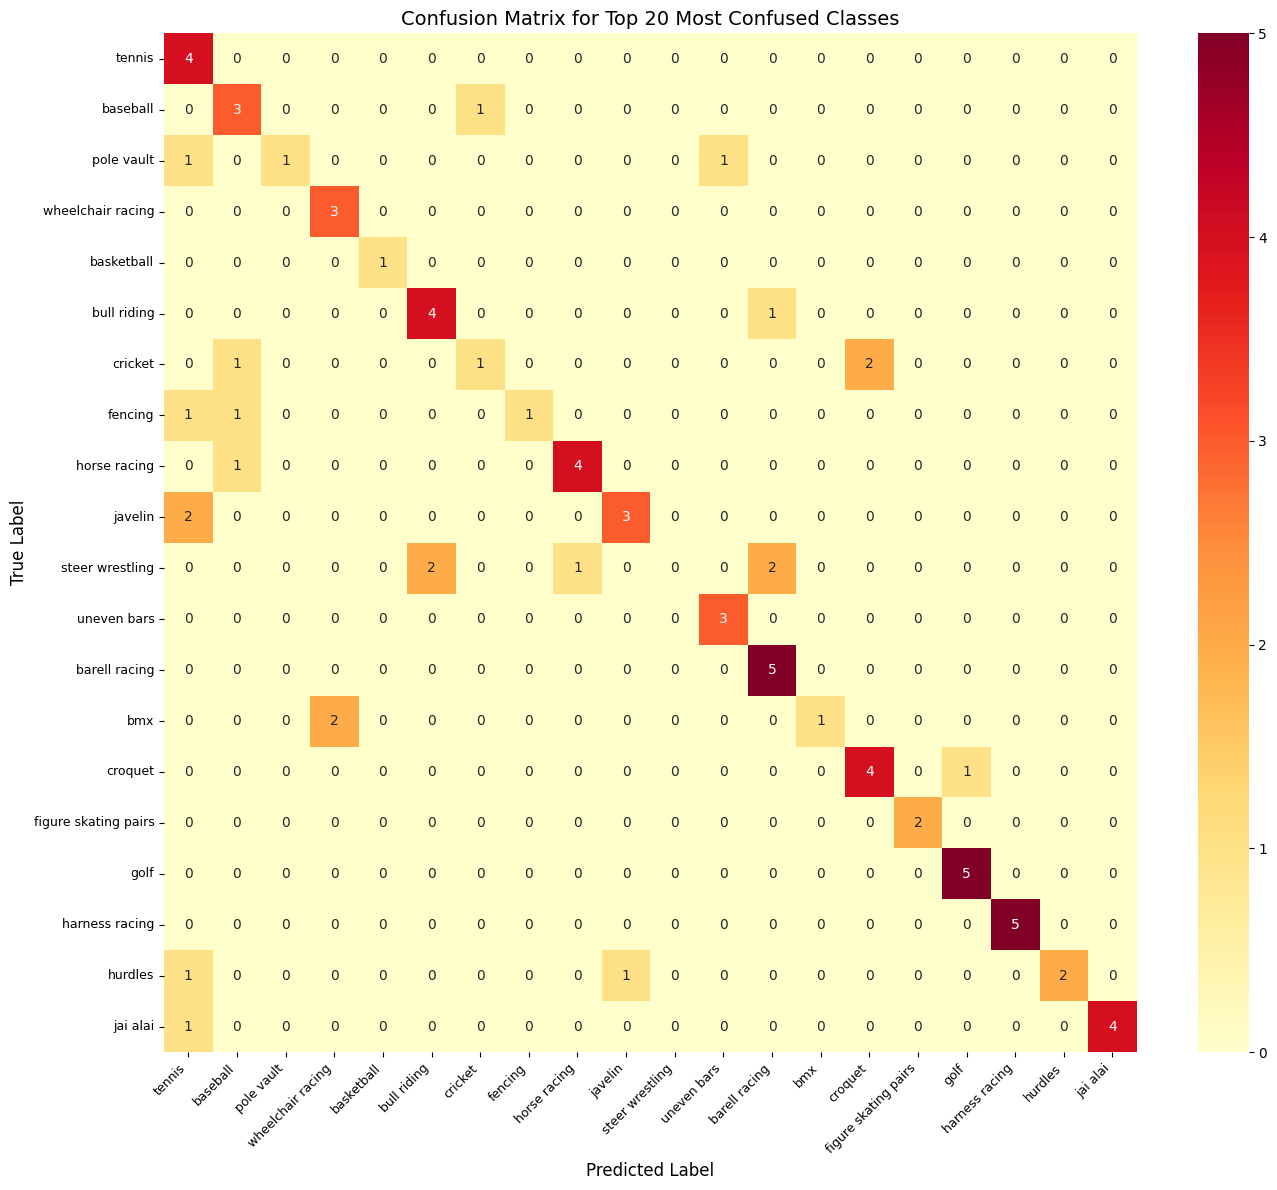

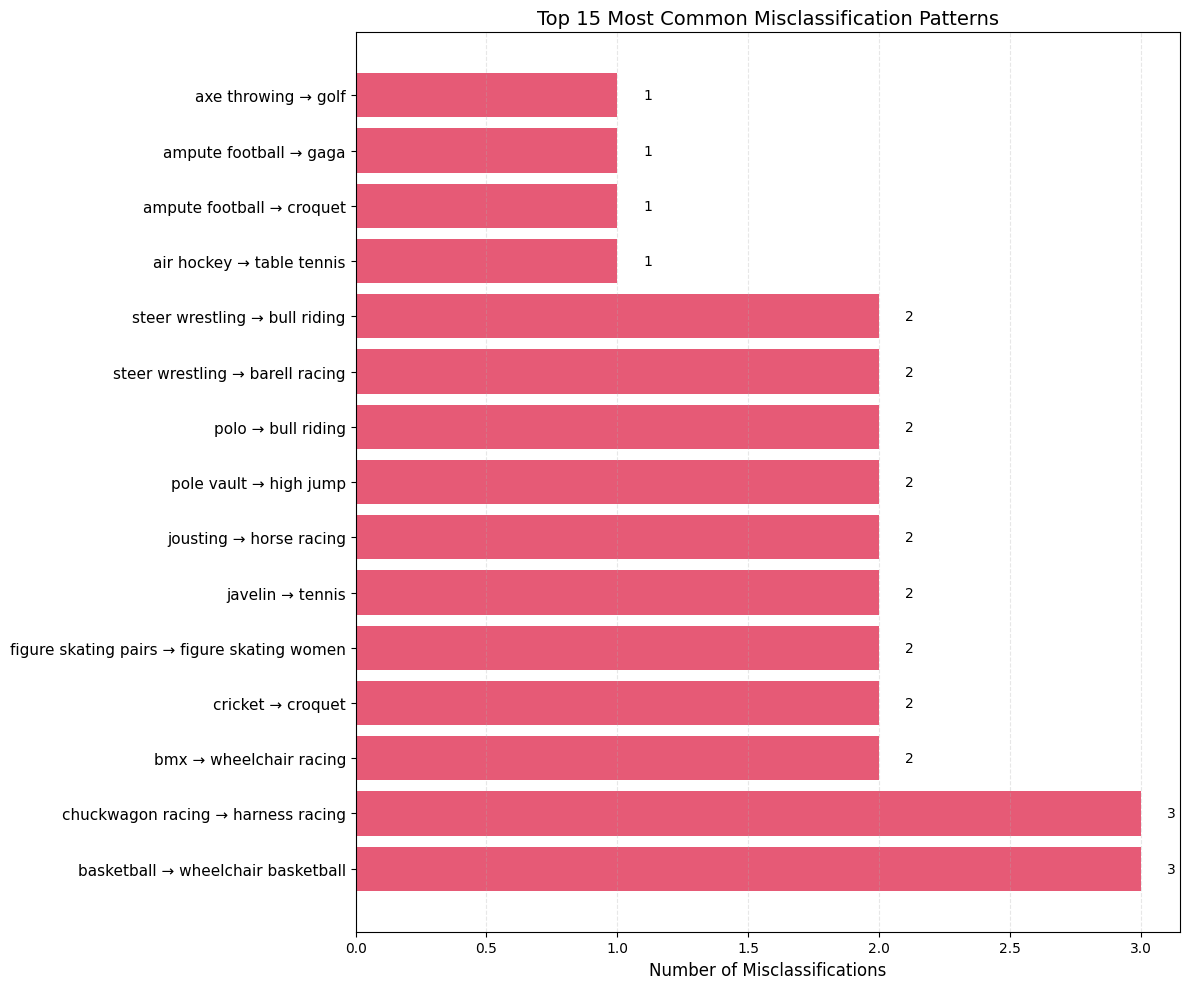

In [36]:
plt.figure(figsize=(16, 10))

# Plot worst classes
plt.subplot(2, 1, 1)
ax1 = sns.barplot(x=worst_classes.index, y='recall', data=worst_classes, color='red', alpha=0.7)
plt.title('15 Worst Performing Classes (by Recall)', fontsize=14)
plt.ylabel('Recall Score', fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.ylim(0, 1.0)
for i, v in enumerate(worst_classes['recall']):
    ax1.text(i, v + 0.05, f"{v:.2f}", ha='center', fontsize=9)
plt.grid(axis='y', linestyle='--', alpha=0.3)

# Plot best classes
plt.subplot(2, 1, 2)
ax2 = sns.barplot(x=best_classes.index, y='recall', data=best_classes, color='green', alpha=0.7)
plt.title('15 Best Performing Classes (by Recall)', fontsize=14)
plt.ylabel('Recall Score', fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.ylim(0, 1.0)
for i, v in enumerate(best_classes['recall']):
    ax2.text(i, v - 0.05, f"{v:.2f}", ha='center', fontsize=9, color='black')
plt.grid(axis='y', linestyle='--', alpha=0.3)

plt.tight_layout()
plt.savefig('class_performance.png', dpi=300, bbox_inches='tight')
plt.show()

# Compare precision and recall for interesting classes
plt.figure(figsize=(16, 8))
interesting_classes = pd.concat([worst_classes.head(10), best_classes.head(10)])
interesting_classes = interesting_classes.sort_values(by='support', ascending=False).head(15)

x = np.arange(len(interesting_classes.index))
width = 0.35

fig, ax = plt.subplots(figsize=(14, 7))
rects1 = ax.bar(x - width/2, interesting_classes['precision'], width, label='Precision', color='blue', alpha=0.7)
rects2 = ax.bar(x + width/2, interesting_classes['recall'], width, label='Recall', color='orange', alpha=0.7)

ax.set_title('Precision vs Recall for Key Classes', fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels(interesting_classes.index, rotation=45, ha='right', fontsize=10)
ax.legend()
ax.grid(axis='y', linestyle='--', alpha=0.3)

# Add value labels
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(rect.get_x() + rect.get_width()/2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=8)

autolabel(rects1)
autolabel(rects2)

plt.tight_layout()
plt.savefig('precision_recall_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# Confusion matrix focusing on most confused classes
cm = confusion_matrix(y_true_list, y_pred_list)

# Find the classes with the most confusion
confusion_scores = []
for i in range(len(class_names)):
    # Sum of false positives and false negatives for this class
    confusion_score = np.sum(cm[i, :]) + np.sum(cm[:, i]) - 2*cm[i, i]
    confusion_scores.append((i, confusion_score))

# Sort and get indices of most confused classes
confusion_scores.sort(key=lambda x: x[1], reverse=True)
top_confused_indices = [idx for idx, _ in confusion_scores[:20]]

# Create a reduced confusion matrix with just these classes
reduced_cm = cm[np.ix_(top_confused_indices, top_confused_indices)]
reduced_class_names = [class_names[i] for i in top_confused_indices]

plt.figure(figsize=(14, 12))
sns.heatmap(reduced_cm, annot=True, fmt='d', cmap='YlOrRd', 
            xticklabels=reduced_class_names, yticklabels=reduced_class_names)
plt.title('Confusion Matrix for Top 20 Most Confused Classes', fontsize=14)
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=9)
plt.yticks(fontsize=9)
plt.tight_layout()
plt.savefig('confusion_matrix_top20.png', dpi=300, bbox_inches='tight')
plt.show()

# Find and visualize the most common misclassification pairs
misclassification_pairs = []
for i in range(len(class_names)):
    for j in range(len(class_names)):
        if i != j and cm[i, j] > 0:
            misclassification_pairs.append((class_names[i], class_names[j], cm[i, j]))

# Sort by frequency and get top pairs
misclassification_pairs.sort(key=lambda x: x[2], reverse=True)
top_pairs = misclassification_pairs[:15]

# Create a horizontal bar chart for top confused pairs
plt.figure(figsize=(12, 10))
pair_labels = [f"{true} → {pred}" for true, pred, _ in top_pairs]
pair_values = [count for _, _, count in top_pairs]

y_pos = np.arange(len(pair_labels))
plt.barh(y_pos, pair_values, align='center', color='crimson', alpha=0.7)
plt.yticks(y_pos, pair_labels, fontsize=11)
plt.xlabel('Number of Misclassifications', fontsize=12)
plt.title('Top 15 Most Common Misclassification Patterns', fontsize=14)
plt.grid(axis='x', linestyle='--', alpha=0.3)

# Add value labels
for i, v in enumerate(pair_values):
    plt.text(v + 0.1, i, str(v), va='center', fontsize=10)

plt.tight_layout()
plt.savefig('top_misclassifications.png', dpi=300, bbox_inches='tight')
plt.show()